In [1]:
import numpy as np
import pandas as pd

In [2]:
from ga4stpg.util import STEIN_B
from ga4stpg.graph import ReaderORLibrary
from ga4stpg.graph.util import is_steiner_tree

from ga4stpg.tree.evaluation import EvaluateTreeGraph
from ga4stpg.tree.mstcrossover import CrossoverPrimUnion
from ga4stpg.tree.generate import GenerateBasedRandomWalk
from ga4stpg.tree.mutate import ReplaceByRandomEdge, PrimBasedMutation, Prunning
from ga4stpg.tree.kruskalpartitioning import KruskalBasedPartitioning

In [3]:
from ga4stpg.condition import BestKnownReached, Stagnation
from ga4stpg.customevol import GeneticEvolution as Evolution
from ga4stpg.customevol import GeneticPopulation as GPopulation
from ga4stpg.normalization import normalize
from ga4stpg.selector import roullete
from ga4stpg.tracker import DataTracker
from ga4stpg.util import STEIN_B, display, update_best, update_generation

In [4]:
from matplotlib import pyplot as plt

In [5]:
from os import path
import config

In [6]:
# import seaborn as sns
# from matplotlib import pyplot as plt 
# import numpy as np
# import pandas as pd
# from scipy import stats

In [7]:
STEIN_B

[('steinb1.txt', 82),
 ('steinb2.txt', 83),
 ('steinb3.txt', 138),
 ('steinb4.txt', 59),
 ('steinb5.txt', 61),
 ('steinb6.txt', 122),
 ('steinb7.txt', 111),
 ('steinb8.txt', 104),
 ('steinb9.txt', 220),
 ('steinb10.txt', 86),
 ('steinb11.txt', 88),
 ('steinb12.txt', 174),
 ('steinb13.txt', 165),
 ('steinb14.txt', 235),
 ('steinb15.txt', 318),
 ('steinb16.txt', 127),
 ('steinb17.txt', 131),
 ('steinb18.txt', 218)]

In [8]:
INDEX = 14

instance_problem = STEIN_B[INDEX][0]
filename = path.join(config.dataset_directory, instance_problem)
stpg = ReaderORLibrary().parser(filename)

print("STPG information", '\n', 10*'- ','\n')
print('Instance: ', stpg.name)
print('Best Known cost: ', STEIN_B[INDEX][1])
print("Nro. Node:", stpg.nro_nodes)
print("Nro. Edges:", stpg.nro_edges)
print("Nro. Terminals:", stpg.nro_terminals)
print("Terminals: \n", stpg.terminals)

STPG information 
 - - - - - - - - - -  

Instance:  B15
Best Known cost:  318
Nro. Node: 100
Nro. Edges: 125
Nro. Terminals: 50
Terminals: 
 {2, 5, 6, 7, 10, 11, 12, 16, 17, 18, 19, 20, 23, 24, 27, 28, 29, 30, 31, 32, 35, 36, 42, 43, 45, 47, 48, 50, 51, 53, 55, 56, 57, 59, 61, 66, 67, 73, 74, 77, 79, 80, 81, 82, 88, 90, 91, 94, 95, 100}


In [9]:
generator = GenerateBasedRandomWalk(stpg)
evaluator = EvaluateTreeGraph(stpg)
crossover = CrossoverPrimUnion(stpg)
prunner   = Prunning(stpg)
mut_prim  = PrimBasedMutation(stpg)
replace_random = ReplaceByRandomEdge(stpg)

kruskal_partition_crossover = KruskalBasedPartitioning(stpg)

In [10]:
output_data_dir = path.join("data", stpg.name)
tracker = DataTracker('001',target=output_data_dir)

In [11]:
population = (GPopulation(
        chromosomes=[ generator() for _ in range(100)],
        eval_function=evaluator,
        maximize=True)
    .evaluate()
    .normalize(norm_function=normalize)
    .callback(update_best))

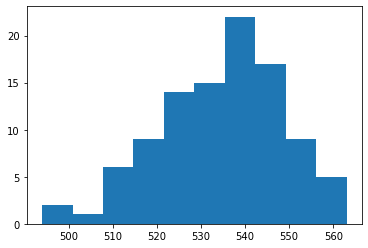

In [12]:
_costs = [x.cost for x in population]
_ = plt.hist(_costs)

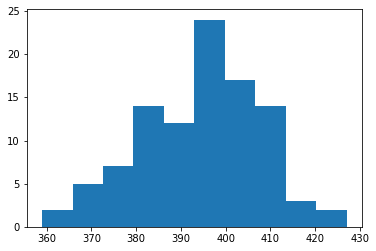

In [13]:
_costs = list()
for individual in population:
    tree = prunner(individual.chromosome)
    _cost,_ = evaluator(tree)
    _costs.append(_cost)

_ = plt.hist(_costs)

In [14]:
len(population)

100

In [15]:
evol = (Evolution()
        .evaluate()
        .normalize(norm_function=normalize)
        .callback(update_best)
        .callback(tracker.log_evaluation)
        .select(selection_func=roullete)
        .crossover(combiner=crossover)
        .mutate(mutate_function=replace_random, probability=0.2)
        .mutate(mutate_function=mut_prim, probability=0.2)
        .mutate(mutate_function=prunner, probability=0.2)
        .callback(update_generation)
        .callback(display, every=100))

In [16]:
%%time
result = population.evolve(evol, n=200)

Population a9c4b0 | size 100 | generation 100 | best cost 330
Population a9c4b0 | size 100 | generation 200 | best cost 330
Wall time: 46.4 s


In [17]:
result.evaluate()

<Population with size 100 at 1811250969608>

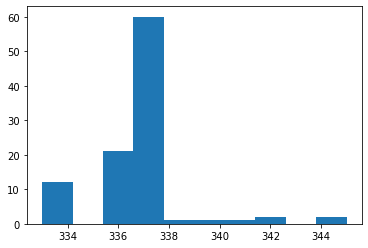

In [18]:
_costs = [x.cost for x in result]
_ = plt.hist(_costs)

In [19]:
min(_costs), max(_costs)

(333, 345)

In [20]:
best_overall = result.documented_best

best_overall.cost

330

In [21]:
from random import choice

# best_tree = best_overall.chromosome
data  = list()
costs = list()

_population = [ x.chromosome for x in result]
# _population.append(best_overall.chromosome)
# _result = iter(result)

for _ in range(100):
    red = choice(_population)
    blue = choice(_population)
    new_tree = kruskal_partition_crossover(red, blue)
    _cost, _ = evaluator(new_tree)
    data.append(new_tree)
    costs.append(_cost)


In [22]:
min(costs), max(costs)

(333, 337)

In [23]:
# best_overall = result.documented_best
# for individual in population:
#     tree = prunner(individual.chromosome)

In [24]:
best_tree = result.documented_best.chromosome
children = list()
_costs = list()

for individual in population:
    # tree = prunner(individual.chromosome)
    tree = individual.chromosome
    child = kruskal_partition_crossover(tree, best_tree)
    child = prunner(child)
    cost, _ = evaluator(child)
    _costs.append(cost)
    children.append(child)


In [25]:
min(_costs), max(_costs)

(328, 330)

In [26]:
index = _costs.index(min(_costs))

print(index)

is_steiner_tree(children[index], stpg)

3


(True,
 {'has_cycle': False,
  'all_terminals_in': True,
  'all_leaves_are_terminals': True,
  'all_edges_are_reliable': True,
  'graph_is_connected': True})

In [27]:
_check = list()

for child in children:
    _, r = is_steiner_tree(child, stpg)
    _check.append(r)

In [28]:
frame = pd.DataFrame(_check)

frame.head()

,has_cycle,all_terminals_in,all_leaves_are_terminals,all_edges_are_reliable,graph_is_connected
0,False,True,True,True,True
1,False,True,True,True,True
2,False,True,True,True,True
3,False,True,True,True,True
4,False,True,True,True,True


In [29]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   has_cycle                 100 non-null    bool 
 1   all_terminals_in          100 non-null    bool 
 2   all_leaves_are_terminals  100 non-null    bool 
 3   all_edges_are_reliable    100 non-null    bool 
 4   graph_is_connected        100 non-null    bool 
dtypes: bool(5)
memory usage: 628.0 bytes


In [30]:
frame[~frame['all_terminals_in']]

,has_cycle,all_terminals_in,all_leaves_are_terminals,all_edges_are_reliable,graph_is_connected
